# Preprations
## Import Packages

In [1]:
from pdf2image import pdf2image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style

matplotlib.style.use("bmh")

import hbsir

## Load Article Images

In [2]:
article_link = "https://naseramanzadeh.ir/wp-content/uploads/2023/09/Intragen__Income_Mobility-2.pdf"

try:
    with open("article.pdf", mode="rb") as pdf_file:
        pdf_content = pdf_file.read()
except FileNotFoundError:
    import requests

    report_file = requests.get(article_link)
    pdf_content = report_file.content
    with open("article.pdf", mode="wb") as pdf_file:
        pdf_file.write(pdf_content)
report_pages = pdf2image.convert_from_bytes(pdf_content, dpi=100)

## Define Functions

In [3]:
def build_columns_tuples(dataframe: pd.DataFrame, columns: list) -> list[tuple]:
    return list(zip(*[dataframe[column] for column in columns]))


def build_columns_series(
        dataframe: pd.DataFrame,
        columns: list,
        index: tuple = ("Year", "ID", "Member_Number")
) -> pd.Series:
    return pd.Series(
        data=build_columns_tuples(dataframe, columns),
        index=pd.MultiIndex.from_frame(dataframe[list(index)])
    )

## Set Parameters

In [4]:
YEARS = range(1389, 1399)

## Load Tables
### household information

In [5]:
hh_info = hbsir.load_table("household_information", years=YEARS)
hh_info.head()

,Year,ID,Season,Month,Weight,Household_Type,Main_Household,Alternative_Household
0,1389,1.000073e+09,Spring,2.0,311.639587,Normal,True,False
1,1389,1.000073e+09,Spring,2.0,311.639587,Normal,True,False
2,1389,1.000073e+09,Spring,2.0,311.639587,Normal,True,False
3,1389,1.000109e+09,Spring,2.0,447.012421,Normal,True,False
4,1389,1.000109e+09,Spring,2.0,447.012421,Normal,True,False


### members properties

In [6]:
members = (
    hbsir.load_table("members_properties", years=YEARS)
    .dropna(subset="Member_Number")
    .assign(Member_Number=lambda df: df["Member_Number"].astype(int))
)
members.head()

,ID,Member_Number,Relationship,Sex,Age,Is_Literate,Is_Student,Education_Level,Activity_State,Marrital_State,Year
0,1000073111,1,Head,Male,30.0,True,False,214,Employed,Married,1389
1,1000073111,2,Spouse,Female,22.0,True,True,323,Student,Married,1389
2,1000073111,3,Child,Male,3.0,<NA>,<NA>,None,NaN,NaN,1389
3,1000073119,1,Head,Male,49.0,True,False,512,Employed,Married,1389
4,1000073119,2,Spouse,Female,49.0,True,False,106,Housekeeper,Married,1389


## Create filters
### Altarnative households information

In [7]:
moving_info = pd.Series(
    data = (
        pd.Categorical(
            hh_info["Alternative_Household"]
            .fillna(False)
            .astype(int),
        )
        .rename_categories({0: "not_moved", 1: "moved"})
    ),
    index=pd.MultiIndex.from_frame(hh_info[["Year", "ID"]]),
)
(
    moving_info
    .groupby("Year").apply(lambda df: df.value_counts())
    .unstack()
    .rename_axis(None, axis="columns")
    .assign(moved_ratio = lambda df: df.eval("moved / (moved + not_moved) * 100"))
)

,not_moved,moved,moved_ratio
Year,,,
1389,33897,5053,12.973042
1390,35285,4726,11.811752
1391,35920,4087,10.215712
1392,32730,7134,17.895846
1393,32944,6912,17.342433
1394,32812,7045,17.675691
1395,32974,6890,17.283765
1396,29941,8021,21.129024
1397,28378,10582,27.161191


### Time difference

In [8]:
time_differences = (
    hh_info
    .assign(Year = lambda df: df["Year"] + 1)
    .set_index(["Year", "ID"])["Month"]
    .add(12)
    .subtract(
        hh_info
        .set_index(["Year", "ID"])["Month"]
    )
    .dropna()
    .astype(int)
)
time_filter = (10 <= time_differences) & (time_differences <= 14)

(
    time_differences
    .value_counts()
    .sort_index()
    .div(time_differences.count())
    .mul(100)
    .to_frame("Portion")
)

,Portion
Month,
1,0.468409
2,0.295837
7,0.002529
10,1.215588
11,3.419830
12,88.997124
13,3.770663
14,1.029110
22,0.343879


### Same members' properties

In [9]:
panel_households = (
    build_columns_series(members, ["Year", "ID"])
    .isin(build_columns_tuples(members.eval("Year = Year + 1"), ["Year", "ID"]))
    .groupby(["Year", "ID"]).all()
)

In [10]:
columns = ["Year", "ID", "Relationship", "Sex", "Age", "Marrital_State"]

lead_df = (
    pd.concat(
        [
            members,
            members.eval("Age = Age + 1"),
        ]
    )
    .eval("Year = Year + 1")
)

lead_set = build_columns_tuples(lead_df, columns)
same_members_lead = build_columns_series(members, columns).isin(lead_set)

lag_df = (
    pd.concat(
        [
            members,
            members.eval("Age = Age - 1"),
        ]
    )
)

lag_set = build_columns_tuples(lag_df, columns)
same_members_lag = (
    build_columns_series(members.eval("Year = Year + 1"), columns).isin(lag_set)
)

member_filter = (
    (same_members_lead & same_members_lag)
    .groupby(["Year", "ID"]).all()
)

### Final filter

In [11]:
# final_filter = member_filter & time_filter
final_filter = member_filter

# Fiqures and Tables
## Fiqure 1: Expenditure per capita and Gini index from 1990 to 2019

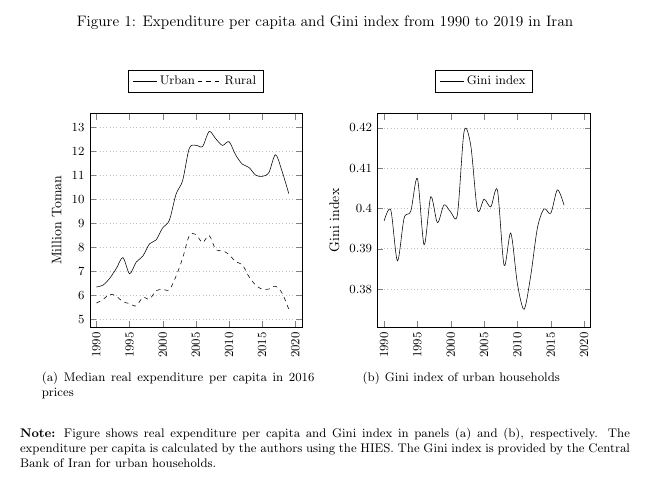

In [12]:
report_pages[18].crop((100, 300, 750, 800))

In [13]:
YEARS = range(1369, 1399)
median_expenditure = (
    hbsir.load_table("Total_Expenditure", years=YEARS)
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .merge(
        hbsir.external_data.load_table("cpi_1395", data_source="SCI", frequency="Annual", separate_by="Urban_Rural"),
        on=["Year", "Urban_Rural"],
    )
    .merge(hbsir.load_table("Equivalence_Scale", years=YEARS), on=["Year", "ID"])
    .assign(
        Real_Expenditure =
        lambda df: df.eval("Gross_Expenditure / OECD_Modified * 100 / CPI / 1e7")
    )
    .groupby(["Year", "Urban_Rural"])["Real_Expenditure"].median()
    .unstack()
    .set_axis(pd.Index([year+ 621 for year in YEARS], name="Year"), axis="index")
)

In [14]:
gini = (
    hbsir.external_data.load_table("Gini", data_source="CBI")
    .query("1369 <= Year <= 1398")
    .eval("Year = Year + 621")
    .set_index("Year")
)

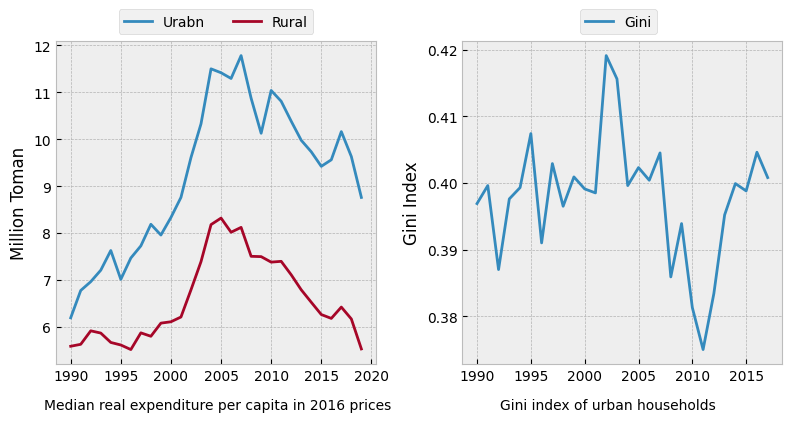

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(median_expenditure.index, median_expenditure["Urban"], label="Urabn")
ax1.plot(median_expenditure.index, median_expenditure["Rural"], label="Rural")
ax1.set_ylabel("Million Toman")
ax1.legend(bbox_to_anchor=(0.5, 1.12), loc='upper center', ncols=2)

ax2.plot(gini.index, gini["Gini"], label="Gini")
ax2.set_ylabel("Gini Index")
ax2.legend(bbox_to_anchor=(0.63, 1.12))

fig.text(0.06, -0.03 , "Median real expenditure per capita in 2016 prices")
fig.text(0.63, -0.03 , "Gini index of urban households")

fig.tight_layout(pad=1)

## Figure 2: Absolute intagenerational mobility from 2011 to 2021 using panel data

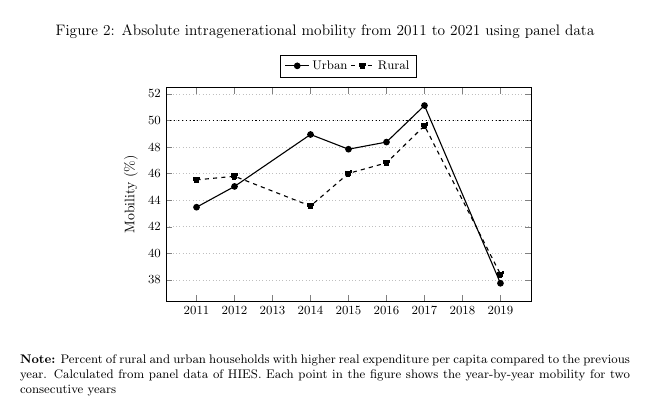

In [16]:
report_pages[19].crop((100, 340, 750, 750))

In [17]:
YEARS = range(1388, 1399)

real_income = (
    hbsir.load_table("Total_Expenditure", years=YEARS)
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .merge(
        hbsir.external_data.load_table("cpi_1395", data_source="SCI", frequency="Annual", separate_by="Urban_Rural"),
        on=["Year", "Urban_Rural"],
    )
    .merge(hbsir.load_table("Equivalence_Scale", years=YEARS), on=["Year", "ID"])
    .assign(
        Real_Expenditure =
        lambda df: df.eval("Gross_Expenditure / OECD_Modified * 100 / CPI / 1e7")
    )
    .set_index(["Year", "ID"])
)

In [18]:
year_id = pd.MultiIndex.from_frame(
    final_filter.to_frame()
    .loc[final_filter]
    .reset_index()
    .pipe(
        lambda df:
        pd.concat(
            [df, df.eval("Year = Year - 1")],
            ignore_index=True
        )
    )
    .loc[:, ["Year", "ID"]]
    .drop_duplicates()
)

In [19]:
weights = (
    hbsir.load_table("Weights", years=YEARS)
    .set_index(["Year", "ID"])
    .loc[year_id]
    .unstack("Year")
)

In [20]:
aiim = (
    real_income
    .loc[year_id, ["Urban_Rural", "Real_Expenditure"]]
    .set_index("Urban_Rural", append=True)
    .unstack("Year")
    .sort_index(axis="columns")
    .pipe(lambda df: df.shift(axis="columns").subtract(df).multiply(-1))
    .droplevel(0, axis="columns")
    .drop(columns=[1389])
    .groupby("Urban_Rural").apply(
        lambda df: df.ge(0).mul(weights).sum().div(df.notna().mul(weights).sum()).mul(100)
    )
    .droplevel(0, axis="columns")
    .transpose()
    .dropna()
    .pipe(lambda df: df.set_axis(df.index + 621, axis="index"))
)

<Axes: xlabel='Year', ylabel='Mobility (%)'>

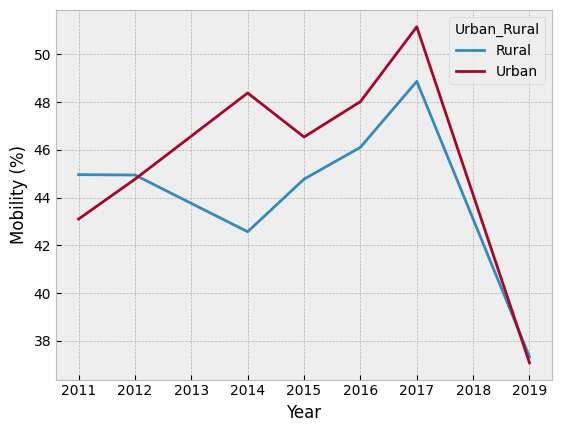

In [21]:
aiim.plot(ylabel="Mobility (%)")

## Figure 3: Transition matrix for HIES panel 2016-17

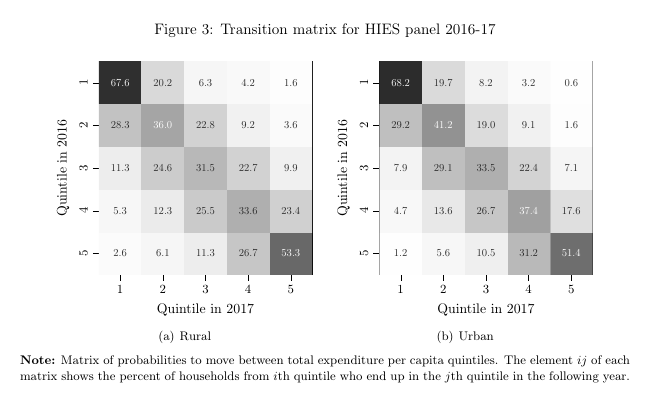

In [22]:
report_pages[20].crop((100, 340, 750, 750))

In [23]:
YEARS = [1395, 1396]
panel_ids = final_filter.loc[final_filter].loc[YEARS[-1]].index

df = (
    hbsir.load_table("Total_Expenditure", years=YEARS)
    .set_index(["Year", "ID"])
    .loc[(slice(None), panel_ids), :]
)
quantile = (
    hbsir.calculator.calculate_quantile(
        table=df,
        on_column="Gross_Expenditure",
        groupby="Urban_Rural",
        weighted=True,
        equivalence_scale="OECD_Modified",
    )
    .multiply(5)
    .floordiv(1)
    .add(1)
    .clip(1,5)
    .astype(int)
)
transition_matrix = (
    quantile.unstack(0)
    .rename(columns={YEARS[0]: str(YEARS[0]+621), YEARS[1]: str(YEARS[1]+621)})
    .assign(Year=YEARS[-1])
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .pipe(hbsir.add_weight)
    .groupby(["Urban_Rural", str(YEARS[0]+621), str(YEARS[1]+621)])[["Weight"]].sum()
    .pipe(
        lambda df:
        df
        .join(df.groupby(["Urban_Rural", str(YEARS[1]+621)])[["Weight"]]
        .transform("sum")
        .rename(columns={"Weight": "Weight_Sum"}))
    )
    .eval("Weight/Weight_Sum*100")
    .unstack([0, 2])
)

Text(0.5, 1.0, 'Urban')

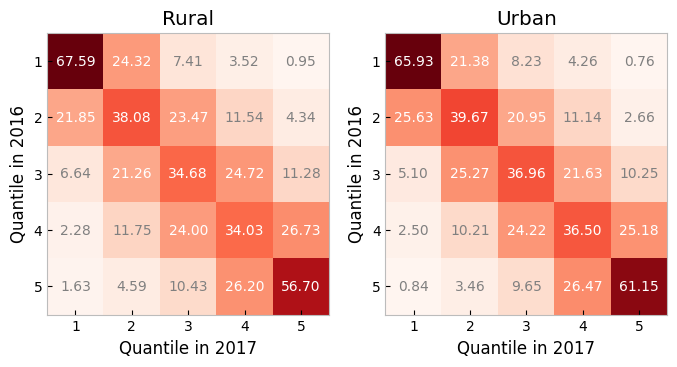

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

table = transition_matrix["Rural"]
ax1.imshow(table, cmap="Reds")
ax1.grid(False)
for i in range(len(table.index)):
    for j in range(len(table.columns)):
        num = f"{table.iloc[i, j]:.2f}"
        if float(num) > 20:
            ax1.text(j, i, num, ha="center", va="center", color="w")
        else:
            ax1.text(j, i, num, ha="center", va="center", color="gray")
ax1.set_xticks(range(5), range(1, 6))
ax1.set_yticks(range(5), range(1, 6))
ax1.set_xlabel(f"Quantile in {YEARS[1]+621}")
ax1.set_ylabel(f"Quantile in {YEARS[0]+621}")
ax1.set_title("Rural")

table = transition_matrix["Urban"]
ax2.imshow(table, cmap="Reds")
ax2.grid(False)
for i in range(len(table.index)):
    for j in range(len(table.columns)):
        num = f"{table.iloc[i, j]:.2f}"
        if float(num) > 20:
            ax2.text(j, i, num, ha="center", va="center", color="w")
        else:
            ax2.text(j, i, num, ha="center", va="center", color="gray")
ax2.set_xticks(range(5), range(1, 6))
ax2.set_yticks(range(5), range(1, 6))
ax2.set_xlabel(f"Quantile in {YEARS[1]+621}")
ax2.set_ylabel(f"Quantile in {YEARS[0]+621}")
ax2.set_title("Urban")

In [25]:
YEARS = range(1397, 1399)

distribution = (
    hbsir.load_table("Total_Expenditure", years=YEARS)
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .merge(
        hbsir.external_data.load_table("cpi_1395", data_source="SCI", frequency="Annual", separate_by="Urban_Rural"),
        on=["Year", "Urban_Rural"],
    )
    .merge(hbsir.load_table("Equivalence_Scale", years=YEARS), on=["Year", "ID"])
    .assign(
        Real_Expenditure =
        lambda df: df.eval("Gross_Expenditure / OECD_Modified * 100 / CPI / 1e7")
    )
    .pipe(hbsir.add_weight)
    .sort_values(["Year", "Real_Expenditure"])
    .assign(Distribution = lambda df: df.groupby(["Year", "Urban_Rural"])["Weight"].transform(lambda s: s.cumsum().div(s.sum())))
    .set_index(["Year", "Urban_Rural", "ID"])
    .loc[:, ["Real_Expenditure", "Distribution"]]
    .sort_values(["Distribution"])
)

In [26]:
def find_income(year, urban_rural, value):
    income_distribution = distribution.loc[(year, urban_rural, slice(None))]
    return (
        income_distribution
        .loc[
                income_distribution["Distribution"]
                .ge(value), "Real_Expenditure"
            ]
        .iloc[0]
    )

In [27]:
theta = 0.12
u_1 = np.random.random(100_000)
u_2 = np.random.random(100_000)

Copula = (
    1/2 *
    pow(theta, -1) *
    (
        1 +
        theta * (u_1 + u_2) -
        (
            pow(
                1 +
                theta * pow(u_1 + u_2, 2) -
                4 * theta * (theta + 1) * u_1 * u_2
                ,
                1/2
            )
        )
    )
)

## Table A1: Number of removed households

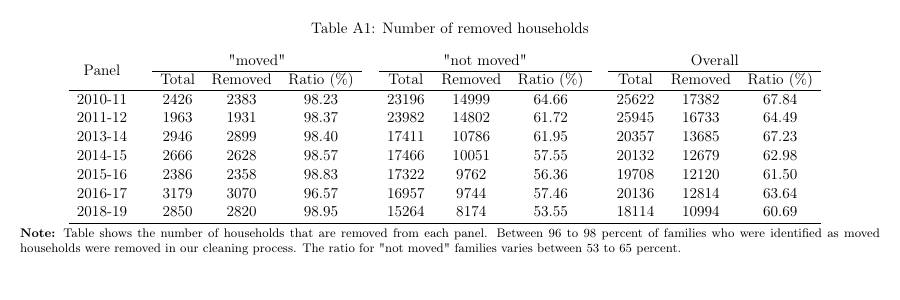

In [28]:
report_pages[32].crop((100, 100, 1000, 400))

In [29]:
table = (
    pd.concat(
        [
            panel_households,
            final_filter,
            moving_info,
        ],
        axis="columns",
        keys=["Total", "Keeped", "Moved"],
    )
    .loc[[1390, 1391, 1393, 1394, 1395, 1396, 1398]]
    .groupby(["Moved", "Year"], observed=True).sum()
    .assign(Removed = lambda df: df["Total"] - df["Keeped"])
    .drop(columns="Keeped")
)

overall = pd.concat([table.groupby("Year").sum()], keys=["overall"], names=["Moved"])

def sort_key(columns: pd.Index) -> pd.Index:
    return columns.map(
        {
            "moved": 0,
            "not_moved": 1,
            "overall": 2,
            "Total": 3,
            "Removed": 4,
            "Ratio": 5
        }
    )

table = (
    pd.concat([table, overall])
    .assign(Ratio = lambda df: df["Removed"] / df["Total"] * 100)
    .unstack(0)
    .reorder_levels([1, 0], axis="columns")
    .sort_index(axis="columns", key=sort_key, sort_remaining=False)
    .rename_axis([None, None], axis="columns")
    .rename_axis("Panel")
)
(
    table
    .style
    .format(thousands=",")
    .format(precision=2, subset=[(cat, "Ratio") for cat in ["moved", "not_moved", "overall"]])
)

## Figure B1: Percent growth in median real expenditure per capita relative to 1990

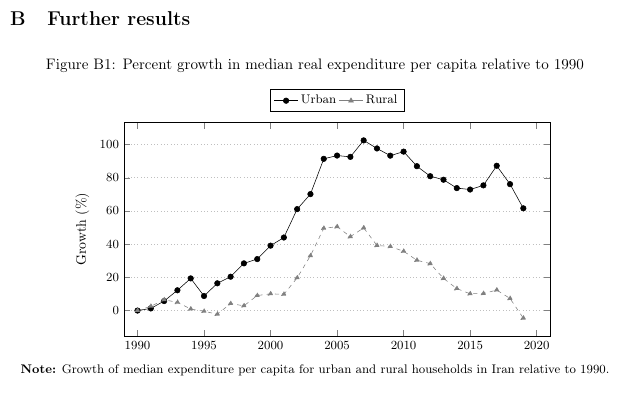

In [30]:
report_pages[33].crop((110, 110, 740, 510))

<Axes: xlabel='Year'>

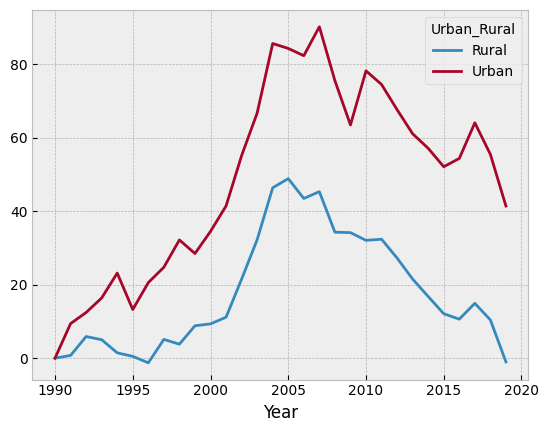

In [31]:
median_expenditure.divide(median_expenditure.loc[1990]).subtract(1).multiply(100).plot.line()

## Figure B2: Median expenditure per capita of each percentile - 2016

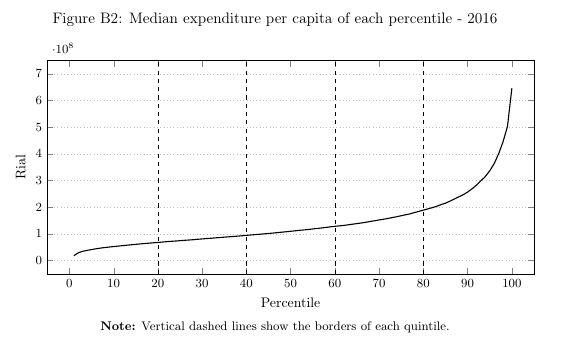

In [32]:
report_pages[34].crop((150, 370, 720, 710))

In [33]:
YEAR = 1396
panel_ids = final_filter.loc[final_filter].loc[YEAR].index

df = (
    hbsir.load_table("Total_Expenditure", years=YEAR)
    .set_index(["Year", "ID"])
    .loc[(slice(None), panel_ids), :]
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .query("Urban_Rural=='Urban'")
    .join(hbsir.load_table("Equivalence_Scale", years=YEAR).set_index(["Year", "ID"]))
    .pipe(hbsir.add_weight)
)
percentile = (
    hbsir.calculator.calculate_percentile(
        table=df,
        on_column="Gross_Expenditure",
        groupby="Urban_Rural",
        weighted=True,
        equivalence_scale="OECD_Modified",
    )
)
df = df.join(percentile)
columns = ["Gross_Expenditure", "Net_Expenditure"]
df.loc[:, columns] = df[columns].divide(df["OECD_Modified"], axis="index").divide(1e7)
df = df.sort_values("Gross_Expenditure")

Text(0, 0.5, 'Million Toman')

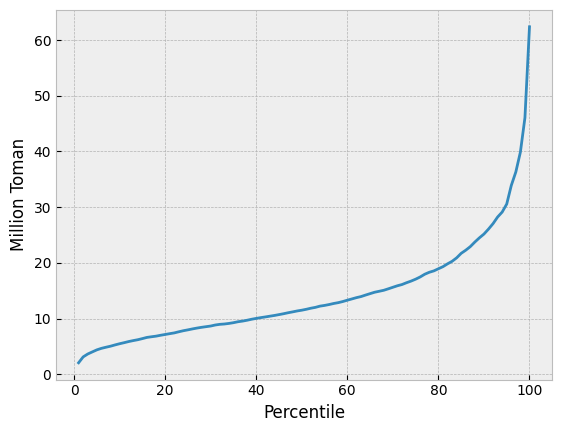

In [34]:
ax = df.groupby("Percentile")["Gross_Expenditure"].median().plot.line()
ax.set_ylabel("Million Toman")